
Este caso requer o desenvolvimento de uma segmentação de clientes para definir a estratégia de marketing. O
O conjunto de dados de amostra resume o comportamento de uso de cerca de 9.000 titulares de cartão de crédito ativos durante os últimos 6 meses. O arquivo está no nível do cliente com 18 variáveis ​​comportamentais.

Para cada segmento, eu devo sugerir de duas a três alavancas de resultados

## Variaveis

- cust_id = identificador do cliente
- balance = valor na conta para realizar compras
- balance_frenquecy = mostra a frequencia que o valor na conta é atualizado para fazer compras, esse valor varia de 0 a 1, sendo 1 muito frequente e 0 pouco frequente
- purchase = quantidade de compras feitas
- oneoff_purchase = o valor máximo feito em uma compra
- installments_purchases = valor das compras parceladas
- cash_advance = valor de saque de dinheiro utilizando o cartão de crédito
- purchase_frequency = mostra a frequencia que as compras são feitas, esse valor varia de 0 a 1, sendo 1 muito frequente e 0 pouco frequente
- oneoffpurchasefrequency= Com que frequência as compras acontecem de uma só vez (1 = comprado com frequência, 0 = não comprado com frequência)
- purchasesinstallmentsfrequency = Com que frequência as compras parceladas estão sendo feitas (1 = frequentemente feito, 0 = não feito com frequência)
- CASHADVANCEFREQUENCY = Com que frequência o dinheiro adiantado está sendo pago
- CASHADVANCETRX = Número de transações feitas com "Cash in Advanced"
- PURCHASES_TRX = Número de transações de compra feitas
- CREDIT_LIMIT = Limite de cartão de crédito para usuário
- PAGAMENTOS = Valor do pagamento feito pelo usuário
- MINIMUM_PAYMENTS = valor mínimo de pagamentos feitos pelo usuário
- PRCFULLPAYMENT = Porcentagem do pagamento integral pago pelo usuário
- ternure = Posse do serviço de cartão de crédito para o usuário


## Plano de Ação

**Sprint #0**
- Fazer o planejamento da solução **(ok)**
- Fazer o notebook end to end **(ok)**

**Sprint #1**
- Fazer a passo 01 - Data Description **(ok)**
    - Tratar os NAs das colunas: **minimum_payments** e **credit_limits**
- Fazer o passo 02 - Filtragem de Linhas e Colunas
- Fazer o passo 03 - Feature Engeneering
- Fazer o passo 04 - EDA (estudo de espaço)

**Sprint #2**
- Fazer a passo 05 - Data Preparation
- Fazer o passo 06 - Feature Selection
- Fazer o passo 07 - Hyperparameter Fine Tunning
- Fazer o passo 08 - Model Training

**Sprint #3**
- Fazer a passo 09 - Cluster Analysis
- Fazer o passo 10 - Model Production
- Fazer o dashboard

# 0.0 Imports

In [1]:
import umap
import inflection
import sqlite3

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn               import metrics
from sklearn.cluster       import KMeans, DBSCAN
from sklearn.manifold      import TSNE
from sklearn.ensemble      import RandomForestRegressor
from sklearn.mixture       import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sqlalchemy            import create_engine

from scipy.cluster         import hierarchy

C:\Users\Lucas\resp\marketing_banco\marketing_banco\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

## 0.2 Loading dataset

In [2]:
df_raw = pd.read_csv('../dados/data.csv')

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
df1.columns = [inflection.underscore(col) for col in df1.columns]

## 1.2 Data Dimensions

In [5]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 8950
Number of Cols: 18


## 1.3 Check DTypes

In [6]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4 Check NAs

In [7]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5 Fillout NAs

In [8]:
# minimum_payments
df1.loc[df1['minimum_payments'].isna(), 'minimum_payments'] = 0.0

#credit_limit
df1.loc[df1['credit_limit'].isna(), 'credit_limit'] = 0.0

In [9]:
df1.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## 1.6 Change DTypes

## 1.7 Descriptive Statistical

In [10]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

### 1.7.1 Numerical Statistical

In [11]:
# medidas de tendência central - media, mediana e desvio padrão
mean = pd.DataFrame(num_attributes.mean()).T
median = pd.DataFrame(num_attributes.median()).T
std = pd.DataFrame(num_attributes.std()).T

# medidas de dispersão - min, max, range, skew e kurtosis
_min = pd.DataFrame(num_attributes.min()).T
_max = pd.DataFrame(num_attributes.max()).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# merge dataframe
m = pd.concat([_min, _max, _range, mean, median, std, skew, kurtosis]).T
m.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,min,max,range,mean,median,std,skew,kurtosis
balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.531879,2.393386,7.674751
balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236904,-2.023266,3.092370
purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.634782,8.144269,111.388771
oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.887917,10.045083,164.187572
installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.338115,7.299120,96.575178
cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.163877,5.166609,52.899434
purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401371,0.060164,-1.638631
oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298336,1.535613,1.161846
purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397448,0.509201,-1.398632
cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200121,1.828686,3.334734


# 2.0 Filtragem de Linhas e Colunas

In [12]:
df2 = df1.copy()

# 3.0 Feature Engineering

In [13]:
df3 = df2.copy()

In [14]:
# pagamento a vista ou não
df3['one_payment'] = df3['oneoff_purchases'].apply(lambda x: 0 if x == 0 else 1)

# Soma das despesas / soma dos pagamentos
df3['debt_rate'] = (df3['purchases'] + df3['cash_advance']) / (df3['payments'] + df3['minimum_payments'])

# percentual gasto do limite do cartao
df3['credit_limit_rate'] = df3['purchases'] + df3['cash_advance'] / (6 * df3['credit_limit'])

In [15]:
# substituindo o valor 'inf' pelo valor máximo do debt_rate
df3.loc[df3['debt_rate'] == np.inf, 'debt_rate'] = df3.loc[df3['debt_rate'] != np.inf, 'debt_rate'].max()

# substituindo o valor 'inf' pelo valor máximo do credit_limit_rate
df3.loc[df3['credit_limit_rate'] == np.inf, 'credit_limit_rate'] = df3.loc[df3['credit_limit_rate'] != np.inf, 'credit_limit_rate'].max()

# 4.0 EDA

In [60]:
df4 = df3.copy()

## 4.3 Estudo do Espaço

In [61]:
mms = MinMaxScaler()

# transform to variables
df4['balance'] = mms.fit_transform(df4[['balance']])
df4['purchases'] = mms.fit_transform(df4[['purchases']])
df4['oneoff_purchases'] = mms.fit_transform(df4[['oneoff_purchases']])
df4['installments_purchases'] = mms.fit_transform(df4[['installments_purchases']])
df4['cash_advance_trx'] = mms.fit_transform(df4[['cash_advance_trx']])
df4['cash_advance'] = mms.fit_transform(df4[['cash_advance']])
df4['purchases_trx'] = mms.fit_transform(df4[['purchases_trx']])
df4['credit_limit'] = mms.fit_transform(df4[['credit_limit']])
df4['payments'] = mms.fit_transform(df4[['payments']])
df4['minimum_payments'] = mms.fit_transform(df4[['minimum_payments']])
df4['prc_full_payment'] = mms.fit_transform(df4[['prc_full_payment']])
df4['tenure'] = mms.fit_transform(df4[['tenure']])
df4['one_payment'] = mms.fit_transform(df4[['one_payment']])
df4['debt_rate'] = mms.fit_transform(df4[['debt_rate']])
df4['credit_limit_rate'] = mms.fit_transform(df4[['credit_limit_rate']])

df43 = df4.drop(columns=['cust_id'])

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

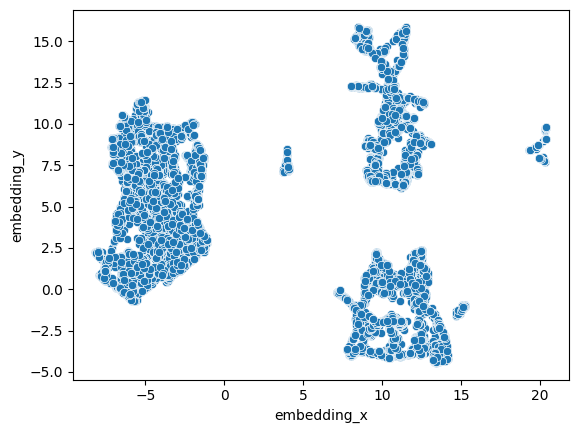

In [62]:
df_umap   = pd.DataFrame()
reducer   = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df43)

# embedding
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)

# 5.0 Data Preparation

In [31]:
df5 = df4.copy()

# 6.0 Feature Selection

In [32]:
cols_selected = ['cust_id', 'purchases', 'oneoff_purchases', 'purchases_trx', 'minimum_payments', 'payments', 'credit_limit_rate', 'cash_advance', 'credit_limit']
df6 = df5[cols_selected].copy()

# 7.0 Hyperparameter Fine Tunning

In [33]:
# espaço de feature
X = df6.drop(columns=['cust_id'])
X.dropna(inplace=True)

# espaço de embedding
X_eb = df_umap.copy()

### 7.1.1. K-Means

In [55]:
km_list = []

for k in clusters:
    # model definition
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model traning
    km.fit(X)
    
    # model predict
    labels = km.predict(X)
    
    # get variance
    km_list.append(metrics.silhouette_score(X, labels))

Text(0, 0.5, 'K')

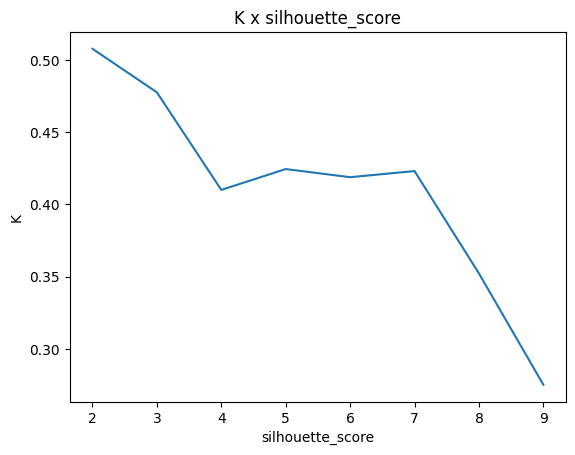

In [56]:
plt.plot(clusters, km_list)
plt.title('K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.1.2. GMM

In [57]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = GaussianMixture(n_components=k, n_init=10, random_state=42) #P.S: use always this 2 parameters: n_init=300, random_state=42, or when running again, values of clustering will change.

    #model training
    gmm_model.fit(X)

    #model predict
    gmm_label = gmm_model.predict(X)

    #model perfomance (SS)
    gmm_ss_vs = metrics.silhouette_score(X, gmm_label, metric='euclidean')
    gmm_list.append(gmm_ss_vs)

Text(0, 0.5, 'K')

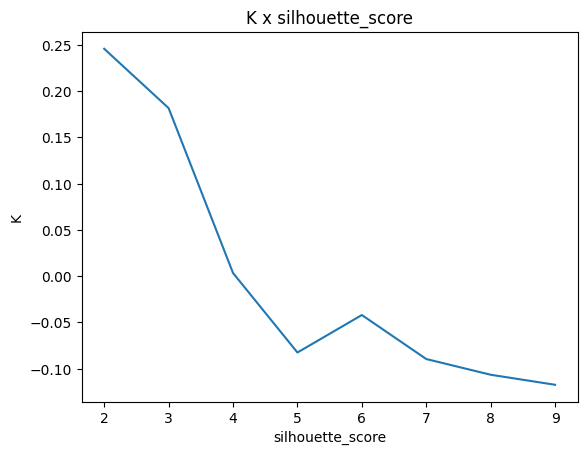

In [58]:
plt.plot(clusters, gmm_list)
plt.title('K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.1.3. DBSCAN

In [59]:
eps = 0.05
min_samples = 20

# model definition
db = DBSCAN(eps = eps, min_samples=min_samples)

# model training
db.fit_predict(X)

# get labels
db_labels = db.labels_

# model performance
print(metrics.silhouette_score(X, labels))

0.2750619463921316


### 7.1.4 Hierarchical Clustering

In [60]:
hc_list = []
for k in clusters:
    #model definition and training
    hc_model = hierarchy.linkage(X, 'ward')

    #model predict
    hc_labels = hierarchy.fcluster(hc_model, k, criterion='maxclust')#to cut dendrogram

    #model perfomance (SS)
    hc_ss_vs = metrics.silhouette_score(X, hc_labels, metric='euclidean')
    hc_list.append(hc_ss_vs) 

Text(0, 0.5, 'K')

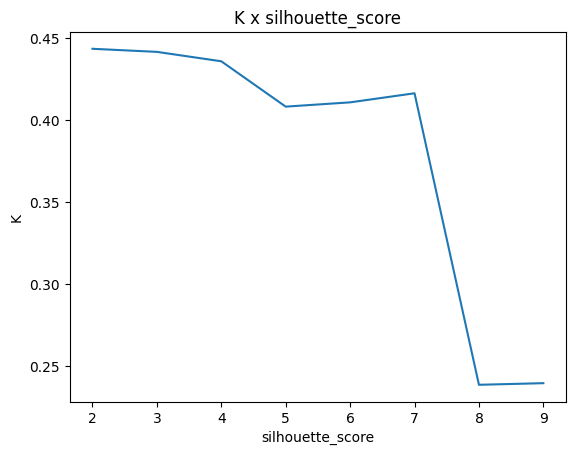

In [61]:
plt.plot(clusters, hc_list)
plt.title('K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.1.5. Results

In [62]:
df_results_vs = pd.DataFrame({'K-Means':km_list, 'GMM':gmm_list, 'HC':hc_list}).T
df_results_vs.columns = clusters

 
df_results_vs.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9
K-Means,0.507761,0.477598,0.410022,0.424463,0.418820,0.423074,0.352187,0.275062
GMM,0.245764,0.181630,0.003428,-0.082470,-0.041958,-0.089532,-0.106509,-0.117350
HC,0.443615,0.441729,0.435987,0.408314,0.410921,0.416460,0.238574,0.239554


### 7.2.1 K-Means

In [63]:
km_list_eb = []

for k in clusters:
    # model definition
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)

    # model traning
    km.fit(X_eb)
    
    # model predict
    labels = km.predict(X_eb)
    
    # get variance
    km_list_eb.append(metrics.silhouette_score(X_eb, labels))

Text(0, 0.5, 'K')

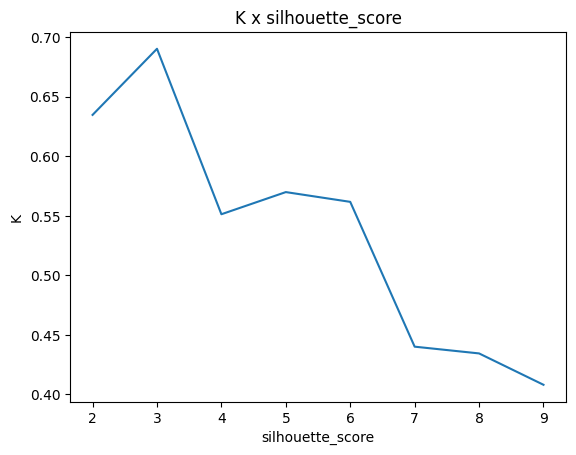

In [64]:
plt.plot(clusters, km_list_eb)
plt.title('K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.2.2. GMM

In [65]:
gmm_list_eb = []
for k in clusters:
    #model definition
    gmm_model = GaussianMixture(n_components=k, n_init=10, random_state=42) #P.S: use always this 2 parameters: n_init=300, random_state=42, or when running again, values of clustering will change.

    #model training
    gmm_model.fit(X_eb)

    #model predict
    gmm_label = gmm_model.predict(X_eb)

    #model perfomance (SS)
    gmm_ss_vs = metrics.silhouette_score(X_eb, gmm_label, metric='euclidean')
    gmm_list_eb.append(gmm_ss_vs)

Text(0, 0.5, 'K')

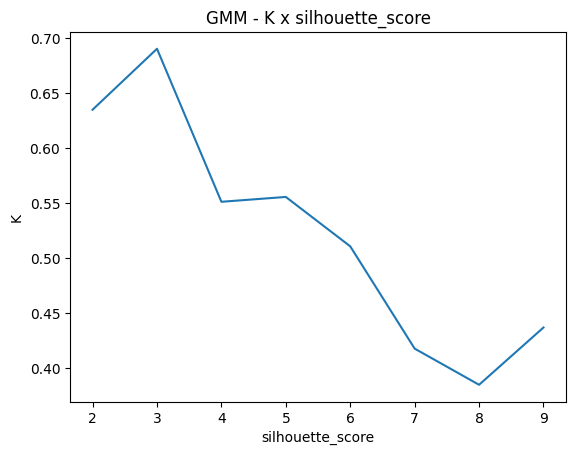

In [66]:
plt.plot(clusters, gmm_list_eb)
plt.title('GMM - K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.2.3. DBSCAN

In [67]:
eps = 0.05
min_samples = 20

# model definition
db = DBSCAN(eps = eps, min_samples=min_samples)

# model training
db.fit_predict(X_eb)

# get labels
db_labels = db.labels_

# model performance
print(metrics.silhouette_score(X_eb, labels))

0.4081041


### 7.2.4. Hierarchical Clustering

In [68]:
hc_list_eb = []
for k in clusters:
    #model definition and training
    hc_model = hierarchy.linkage(X_eb, 'ward')

    #model predict
    hc_labels = hierarchy.fcluster(hc_model, k, criterion='maxclust')#to cut dendrogram

    #model perfomance (SS)
    hc_ss_vs = metrics.silhouette_score(X_eb, hc_labels, metric='euclidean')
    hc_list_eb.append(hc_ss_vs) 

Text(0, 0.5, 'K')

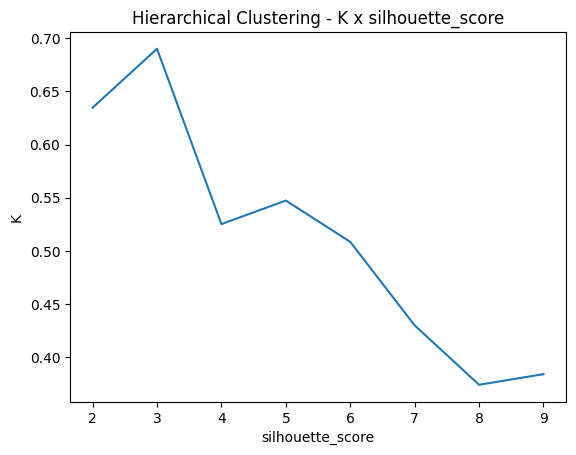

In [69]:
plt.plot(clusters, hc_list_eb)
plt.title('Hierarchical Clustering - K x silhouette_score')
plt.xlabel('silhouette_score')
plt.ylabel('K')

### 7.2.5 Results

In [71]:
df_results_eb = pd.DataFrame({'K-Means':km_list_eb, 'GMM':gmm_list_eb, 'HC':hc_list_eb}).T
df_results_eb.columns = clusters

 
df_results_eb.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9
K-Means,0.634670,0.690169,0.551270,0.569863,0.561665,0.440097,0.434428,0.408104
GMM,0.634670,0.689966,0.551105,0.555496,0.510670,0.417854,0.385018,0.436997
HC,0.634670,0.690169,0.525037,0.547210,0.508330,0.429650,0.373676,0.383678


# 8.0 Model Machine Learning

In [34]:
# model definition
km = KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=42)

# model traning
km.fit(X_eb)

# model predict
labels = km.predict(X_eb)

In [35]:
print('Sillhouette Score: {}'.format(metrics.silhouette_score(X_eb, labels)))

Sillhouette Score: 0.6796582937240601


# 9.0 Cluster Analysis

In [36]:
df9 = X_eb.copy()

## 9.1. Visualization Inspection

In [37]:
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,12.059251,2.178438,2
1,11.154283,11.166090,1
2,-6.627440,3.994949,0
3,3.842172,7.519654,1
4,-5.146797,11.346519,0


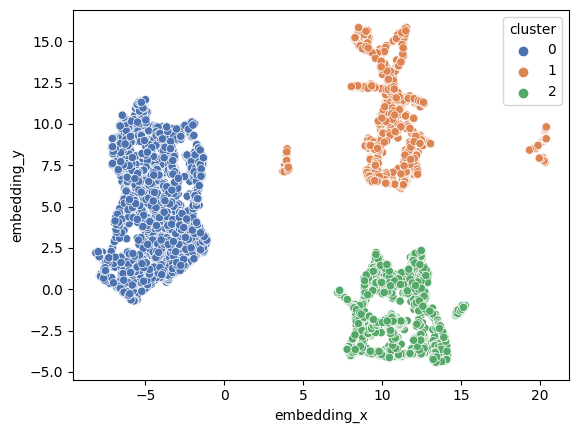

In [38]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');


## 9.2. Cluster Profile

In [39]:
df9p = df3.copy() #df4 contains original values (not reescaled), to use in cluster profile
df9p = df9p[cols_selected]
df9p['cluster'] = labels
df9p

,cust_id,purchases,oneoff_purchases,purchases_trx,minimum_payments,payments,credit_limit_rate,cash_advance,credit_limit,cluster
0,C10001,95.40,0.00,2,139.509787,201.802084,95.400000,0.000000,1000.0,2
1,C10002,0.00,0.00,0,1072.340217,4103.032597,0.153403,6442.945483,7000.0,1
2,C10003,773.17,773.17,12,627.284787,622.066742,773.170000,0.000000,7500.0,0
3,C10004,1499.00,1499.00,1,0.000000,0.000000,1499.004573,205.788017,7500.0,1
4,C10005,16.00,16.00,1,244.791237,678.334763,16.000000,0.000000,1200.0,0
...,...,...,...,...,...,...,...,...,...,...
8945,C19186,291.12,0.00,6,48.886365,325.594462,291.120000,0.000000,1000.0,2
8946,C19187,300.00,0.00,6,0.000000,275.861322,300.000000,0.000000,1000.0,2
8947,C19188,144.40,0.00,5,82.418369,81.270775,144.400000,0.000000,1000.0,2
8948,C19189,0.00,0.00,0,55.755628,52.549959,0.012186,36.558778,500.0,1


In [41]:
# Number of customer
df_cluster = df9p[['cust_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'cust_id':'qtd_users'})
df_cluster['perc_customer'] = df_cluster['qtd_users'] / df_cluster['qtd_users'].sum()*100

# Avg purchases
df_avg_purchases = df9p[['purchases','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_purchases, how='inner', on='cluster')

# Avg oneoff_purchases
df_avg_oneoff_purchases = df9p[['oneoff_purchases','cluster']].groupby('cluster').mean().reset_index().rename(columns={'oneoff_purchases':'avg_oneoff_purchases'})
df_cluster = pd.merge(df_cluster, df_avg_oneoff_purchases, how='inner', on='cluster')

# Avg purchases_trx
df_avg_purchases_trx = df9p[['purchases_trx','cluster']].groupby('cluster').mean().reset_index().rename(columns={'purchases_trx':'avg_purchases_trx'})
df_cluster = pd.merge(df_cluster, df_avg_purchases_trx, how='inner', on='cluster')

# Avg minimum_payments
df_avg_minimum_payments = df9p[['minimum_payments','cluster']].groupby('cluster').mean().reset_index().rename(columns={'minimum_payments':'avg_minimum_payments'})
df_cluster = pd.merge(df_cluster, df_avg_minimum_payments, how='inner', on='cluster')

# Avg payments
df_avg_payments = df9p[['payments','cluster']].groupby('cluster').mean().reset_index().rename(columns={'payments':'avg_payments'})
df_cluster = pd.merge(df_cluster, df_avg_payments, how='inner', on='cluster')

# Avg credit_limit_rate
df_avg_credit_limit_rate = df9p[['credit_limit_rate','cluster']].groupby('cluster').mean().reset_index().rename(columns={'credit_limit_rate':'avg_credit_limit_rate'})
df_cluster = pd.merge(df_cluster, df_avg_credit_limit_rate, how='inner', on='cluster')

# Avg cash_advance
df_avg_cash_advance = df9p[['cash_advance','cluster']].groupby('cluster').mean().reset_index().rename(columns={'cash_advance':'avg_cash_advance'})
df_cluster = pd.merge(df_cluster, df_avg_cash_advance, how='inner', on='cluster')

# Avg credit_limit
df_avg_credit_limit = df9p[['credit_limit','cluster']].groupby('cluster').mean().reset_index().rename(columns={'credit_limit':'avg_credit_limit'})
df_cluster = pd.merge(df_cluster, df_avg_credit_limit, how='inner', on='cluster')

# cluster profiles
df_cluster.sort_values('purchases', ascending=False)

,cluster,qtd_users,perc_customer,purchases,avg_oneoff_purchases,avg_purchases_trx,avg_minimum_payments,avg_payments,avg_credit_limit_rate,avg_cash_advance,avg_credit_limit
0,0,4546,50.793296,1689.740568,1151.026278,22.849758,795.053571,2175.080726,1689.769350,813.930002,5262.703053
2,2,2165,24.189944,550.722203,0.000000,12.175058,824.499680,1013.927408,550.739405,383.110925,3315.387244
1,1,2239,25.016760,46.810661,31.151858,0.633765,922.195875,1531.294175,68.804400,1889.832745,4072.696144


# 10.0. Deploy to Production

In [63]:
# criando o banco
#conn = sqlite3.connect('segmentation.db')

#cursor = conn.cursor()

#query = """
#    CREATE TABLE segmentation_clients (
#        cust_id                TEXT,
#        purchases              REAL,
#        oneoff_purchases       REAL,
#        purchases_trx          INTERGER,
#        minimum_payments       REAL,
#        payments               REAL,
#        credit_limit_rate      REAL,
#        cash_advance           REAL,
#        credit_limit           REAL,
#        cluster                INTEGER
#    )
#"""

#conn.execute(query)


# fechar a conexao
#conn.close()


In [56]:
# insert data
conn = create_engine('sqlite:///segmentation.db')
df9p.to_sql('segmentation_clients', con=conn, if_exists='append', index=False)

8950